This program uses the Stocastic Relative Strength Index to determine if an asset is over bought or over sold.
Referenced: https://www.youtube.com/watch?v=JGB9jm8OWFs

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# load historical data
df = pd.read_csv('BTC-USD.csv')
df = df.set_index(pd.DatetimeIndex(df['Date'].values))
df

,Date,Open,High,Low,Close,Volume
2019-12-08,2019-12-08,7551.338867,7634.606445,7476.091309,7564.345215,1.540991e+10
2019-12-09,2019-12-09,7561.795410,7618.091797,7365.985352,7400.899414,1.787202e+10
2019-12-10,2019-12-10,7397.134277,7424.022949,7246.043945,7278.119629,1.824903e+10
2019-12-11,2019-12-11,7277.197754,7324.156250,7195.527344,7217.427246,1.635049e+10
2019-12-12,2019-12-12,7216.738770,7266.639648,7164.741211,7243.134277,1.892708e+10
...,...,...,...,...,...,...
2021-12-04,2021-12-04,53727.878906,53904.679688,42874.617188,49200.703125,6.138568e+10
2021-12-05,2021-12-05,49201.519531,49768.148438,47857.496094,49368.847656,3.719820e+10
2021-12-06,2021-12-06,49413.480469,50929.519531,47281.035156,50582.625000,3.770731e+10
2021-12-07,2021-12-07,50581.828125,51934.781250,50175.808594,50700.085938,3.367681e+10


In [8]:
# Exponential Moving Average Indicator (20 period)
def ema(data, period=20, column='Close'):
    return data[column].ewm(span=period, adjust=False).mean()

In [51]:
# Calculate Stochastic RSI
def stochRsi(data, period=14, column='Close'):
    delta = data[column].diff(1)
    delta = delta.dropna()
    up = delta.copy()
    down = delta.copy()
    up[up<0] = 0
    down[down>0] = 0
    data['up'] = up
    data['down'] = down
    avgGain = ema(data, period, column='up')
    avgLoss = abs(ema(data, period, column='down'))
    rs = avgGain/avgLoss
    rsi = 100 - (100/(1 + rs))    
    stockRsi = (rsi - rsi.rolling(period).min()) / (rsi.rolling(period).max() - rsi.rolling(period).min())
    return stockRsi

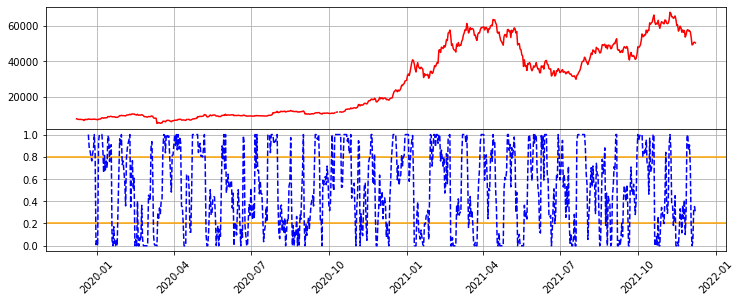

In [52]:
# Store RSI in new column
df['StochRSI'] = stochRsi(df)

# Plot data
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12.2, 4.5), sharex=True)

# Remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)

# Add gridlines
ax1.grid()
ax2.grid()

# # Plot over bought(0.8) and over sold lines
ax2.axhline(0.2, color='orange')
ax2.axhline(0.8, color='orange')

# Plot close price
ax1.plot(df.index, df['Close'], color = 'red')

# Plot StochRSI
ax2.plot(df.index, df['StochRSI'], color = 'blue', linestyle = '--')
plt.xticks(rotation=45)

plt.show()

In [113]:
def buySell(signal):
    buy = []
    sell = []
    isOpenPosition = False
    isCurrentlyOverSold = False
    isCurrentlyOverBought = False
    
    for i in range(0, len(signal)):
        stochRsi = signal['StochRSI'][i]
        if(stochRsi > 0.2 and isCurrentlyOverSold and not isOpenPosition):
            # RSI exits over sold region open a position
            isCurrentlyOverSold = False
            isOpenPosition = True
            buy.append(signal['Close'][i])
            sell.append(np.nan)
        elif(stochRsi < 0.8 and isCurrentlyOverBought and isOpenPosition):
            # RSI exits over bought region close position
            isCurrentlyOverBought = False
            isOpenPosition = False
            buy.append(np.nan)
            sell.append(signal['Close'][i])
        elif(stochRsi < 0.2):
            # RSI enters over sold region
            isCurrentlyOverSold = True
            buy.append(np.nan)
            sell.append(np.nan)
        elif(stochRsi > 0.8):
            # RSI enters over bought region
            isCurrentlyOverBought = True
            buy.append(np.nan)
            sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
            
    return (buy, sell)

In [114]:
# Add buy sell columns
signals = buySell(df)
df['Buy_Signal_Price'] = signals[0]
df['Sell_Signal_Price'] = signals[1]

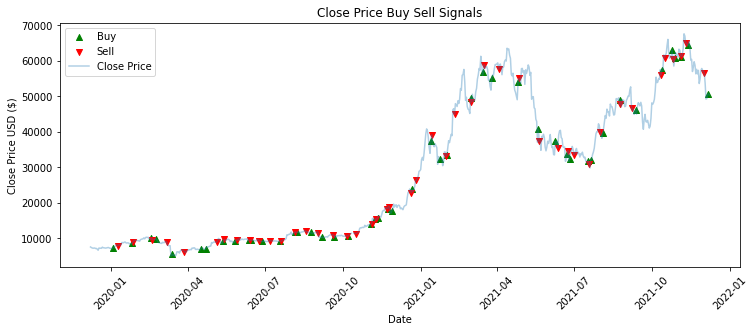

In [115]:
#Visualise buy sell signal
plt.figure(figsize=(12.2, 4.5))
plt.scatter(df.index, df['Buy_Signal_Price'], color = 'green', label='Buy', marker='^', alpha=1)
plt.scatter(df.index, df['Sell_Signal_Price'], color = 'red', label='Sell', marker='v', alpha=1)
plt.plot(df['Close'], label='Close Price', alpha=0.35)
plt.title('Close Price Buy Sell Signals')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend(loc='upper left')
plt.show()

In [125]:
# Tabulate netgains
def tabuatePercentageGains(data):
    openPosition = False
    startingSum = 100
    quantityHeld = 0
    buyingPrice = 0
    for i in range(0, len(data.index)):
        buyPrice = data['Buy_Signal_Price'][i]
        sellPrice = data['Sell_Signal_Price'][i]
        if(not openPosition and not np.isnan(buyPrice)):
            quantityHeld = startingSum/buyPrice
            openPosition = True
            buyingPrice = buyPrice
            print(f"Buy at {buyPrice} USD")
        if(openPosition and not np.isnan(sellPrice)):
            startingSum = sellPrice * quantityHeld
            quantityHeld = 0
            openPosition = False
            print(f"Sell at {sellPrice} USD, portfolio:{startingSum}")
    
    if(openPosition):
        # Assume last open position was not taken since no selling price
        startingSum = quantityHeld * buyingPrice
        print(f"No selling price available, position at {buyingPrice} USD voided")
        
    percentageChange = startingSum - 100
    return percentageChange

percentageGained = tabuatePercentageGains(df)
print(f'Net Gain: {percentageGained}%')

Buy at 7344.884277 USD
Sell at 7879.071289 USD, portfolio:107.27291257226162
Buy at 8596.830078 USD
Sell at 8909.819336 USD, portfolio:111.1784532197862
Buy at 10141.996094 USD
Sell at 9633.386719 USD, portfolio:105.60298236755081
Buy at 9924.515625 USD
Sell at 8909.954102 USD, portfolio:94.80742048095601
Buy at 5563.707031 USD
Sell at 6242.193848 USD, portfolio:106.36906177365772
Buy at 7116.804199 USD
Sell at 9003.070313 USD, portfolio:134.56154131803183
Buy at 9269.987305 USD
Sell at 9733.72168 USD, portfolio:141.29302974504367
Buy at 9181.017578 USD
Sell at 9439.124023 USD, portfolio:145.26520835171144
Buy at 9480.84375 USD
Sell at 9475.277344 USD, portfolio:145.17992004313024
Buy at 9450.702148 USD
Sell at 9313.610352 USD, portfolio:143.0739414956991
Buy at 9143.582031 USD
Sell at 9252.277344 USD, portfolio:144.77474833488898
Buy at 9185.817383 USD
Sell at 9164.231445 USD, portfolio:144.43453922651872
Buy at 11747.022461 USD
Sell at 11779.773438 USD, portfolio:144.83722614466484
B

In [129]:
def buyAndHold(data):
    buyAt = data['Close'][0]
    sellAt = data['Close'][len(data.index)-1]
    return (sellAt - buyAt) * 100 / (buyAt)

performance = 100 * (percentageGained - buyAndHold(df)) / buyAndHold(df)
print(f'StochRSI outperform buy and hold by: {np.round(performance,3)}%')

StochRSI outperform buy and hold by: -2.982%


Conclusion: 
Stochastic RSI as an entry(0.2 over sold) and exit signal(0.8 over bought) is a decent indicator of changing trends, producing mediocre result. However, it alone will not work as a trading indicator since it does not out perform buy and hold.

**Note if 2nd last trade at 64469.527344 not taken, Stochastic RSI would have outperformed buy and hold by 30.963%